### Import libraries

In [1]:
import pandas as pd
import imageio
import sys
sys.path.append('../../utils')
import visualization
import generic
import project_utils
import os
import numpy as np
import matplotlib.pyplot as plt



### Load Data

In [2]:
dengue_data = pd.read_csv('../../data/processed/dengue_data.csv')
health_centers = pd.read_csv('../../data/processed/health_centers.csv')
ovitraps_data = pd.read_csv('../../data/processed/ovitraps_data.csv')

dengue_data.columns

C:\Users\User\AppData\Local\Temp\ipykernel_2324\2989437402.py:1: DtypeWarning: Columns (9,32) have mixed types. Specify dtype option on import or set low_memory=False.
  dengue_data = pd.read_csv('../../data/processed/dengue_data.csv')


Index(['dt_notific', 'CodMun', 'semana', 'dt_nasc', 'nu_idade_n', 'Sexo',
       'id_bairro', 'nm_bairro', 'classi_fin', 'dt_obito', 'coordx', 'coordy',
       'diagnostic', 'abrange', 'cdabrange', 'ano', 'Mes_Caso', 'Dia_Caso',
       'DiaC', 'MesC', 'AnoC', 'Dengue', 'Idade', 'anoepid', 'nanoCepid',
       'Mes_Epid', 'Cseason', 'Clustro', 'Cquinzena', 'Cquinzepid',
       'CaClustro', 'cddist', 'distrito', 'qdnte', 'latitude', 'longitude',
       'closest_health_center', 'semepid', 'epidemic_date'],
      dtype='object')

### Samples 

In [3]:
print(f'Number of samples: {dengue_data.shape[0]}')
print(f'Samples with date: {dengue_data[dengue_data["dt_notific"].notna()].shape[0]}')
print(f'Samples with coordinates: {dengue_data[dengue_data["latitude"].notna()].shape[0]}')
print(f'Samples without coordinates: {dengue_data[dengue_data["latitude"].isna()].shape[0]}')
print(f'Samples without coordinates with neighborhood: {dengue_data[(dengue_data["latitude"].isna() & ~(dengue_data["nm_bairro"].isna()) )].shape[0]}')
print(f'Samples without coordinates without neighborhood: {dengue_data[(dengue_data["latitude"].isna() & (dengue_data["nm_bairro"].isna()) )].shape[0]}')
print(f'Samples without coordinates without neighborhood with district: {dengue_data[(dengue_data["latitude"].isna() & (dengue_data["nm_bairro"].isna()) & ~(dengue_data["distrito"].isna()) )].shape[0]}')
print(f'Samples without coordinates without neighborhood without district: {dengue_data[(dengue_data["latitude"].isna() & (dengue_data["nm_bairro"].isna()) & (dengue_data["distrito"].isna()) )].shape[0]}')


Number of samples: 689107
Samples with date: 689107
Samples with coordinates: 484797
Samples without coordinates: 204310
Samples without coordinates with neighborhood: 197341
Samples without coordinates without neighborhood: 6969
Samples without coordinates without neighborhood with district: 6275
Samples without coordinates without neighborhood without district: 694


In [4]:
print(f'Samples with coordinates without health center: {dengue_data[(dengue_data["latitude"].notna() & (dengue_data["abrange"] == "NAO DETERMINADA"))].shape[0]}')
print(f'Samples without coordinates with health center: {dengue_data[(dengue_data["latitude"].isna() & (dengue_data["abrange"] != "NAO DETERMINADA"))].shape[0]}')
print(f'Samples without coordinates without health center: {dengue_data[(dengue_data["latitude"].isna() & (dengue_data["abrange"] == "NAO DETERMINADA"))].shape[0]}')

Samples with coordinates without health center: 218466
Samples without coordinates with health center: 0
Samples without coordinates without health center: 204310


#### Samples by year


<Axes: title={'center': 'Samples by year'}, xlabel='anoepid'>

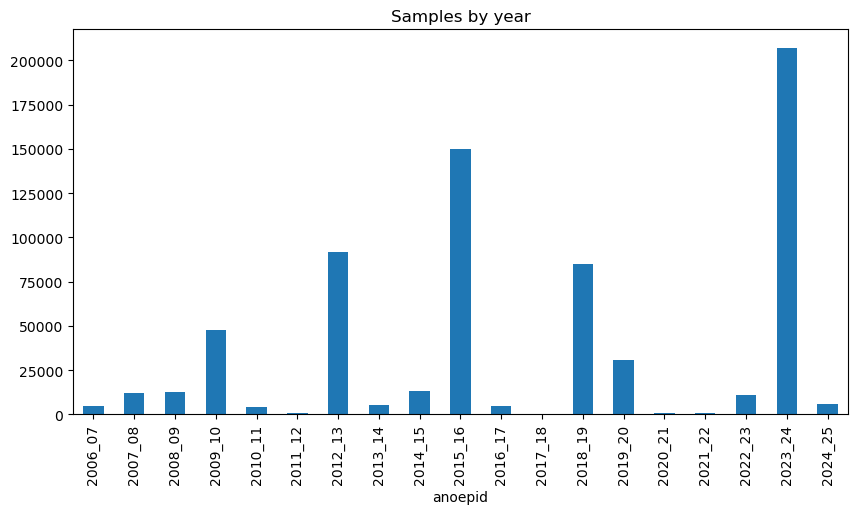

In [5]:
dengue_data['anoepid'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5), title='Samples by year')

In [6]:
for year in dengue_data['anoepid'].unique():
    deaths = dengue_data[dengue_data['anoepid'] == year]['dt_obito'].notna().sum()
    print(f'Number of deaths for {year}: {deaths}')

Number of deaths for 2018_19: 35
Number of deaths for 2023_24: 132
Number of deaths for 2015_16: 53
Number of deaths for 2019_20: 15
Number of deaths for 2024_25: 6
Number of deaths for 2010_11: 0
Number of deaths for 2016_17: 7
Number of deaths for 2012_13: 5
Number of deaths for 2009_10: 2
Number of deaths for 2014_15: 5
Number of deaths for 2006_07: 0
Number of deaths for 2022_23: 10
Number of deaths for 2013_14: 3
Number of deaths for 2007_08: 0
Number of deaths for 2008_09: 0
Number of deaths for 2021_22: 1
Number of deaths for 2020_21: 0
Number of deaths for 2017_18: 1
Number of deaths for 2011_12: 0


#### No Coordinates samples by year


In [7]:
import importlib
importlib.reload(generic)   

<module 'generic' from 'c:\\Users\\User\\Pedro\\personal_projects\\ovitraps\\tcc_ovitraps\\notebooks\\dengue_cases\\../../utils\\generic.py'>

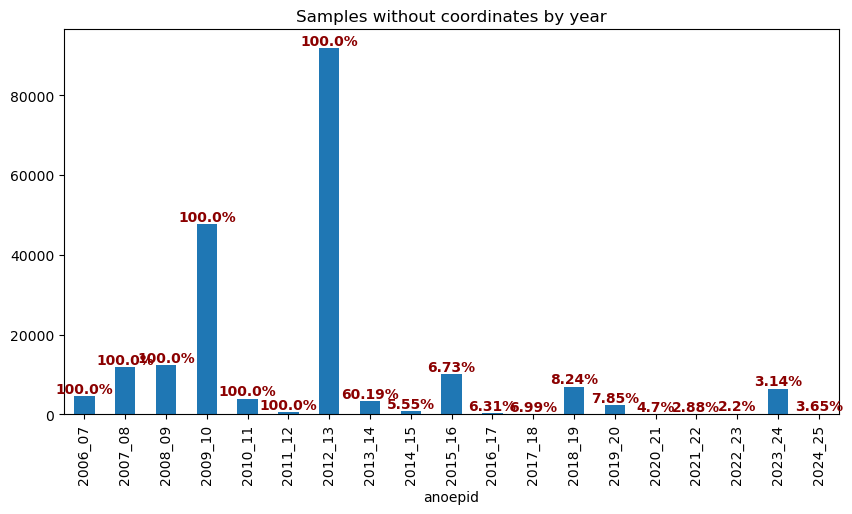

In [8]:
percentage_no_coordinates = dengue_data[dengue_data["latitude"].isna()]['anoepid'].value_counts().sort_index()/dengue_data['anoepid'].value_counts().sort_index() * 100
percentage_no_coordinates = percentage_no_coordinates.round(2).astype(str) + '%'
plot_df = dengue_data[dengue_data["latitude"].isna()]['anoepid'].value_counts().sort_index()
plot_df.plot(kind='bar', figsize=(10, 5), title='Samples without coordinates by year')
generic.text_above_plot(plot_df, percentage_no_coordinates)


According to Dilermando, there's no way to get the coordinates of the samples without coordinates. The abscence of coordinates is due to the lack of register of this field in the beggining of the data collection (before 2014) and the high volume of cases in the epidemies after that year. 


#### Cases with same coordinates

count
1      136216
2       54794
3       25362
4       12241
5        6456
6        3261
7        1956
8        1147
9         742
10        432
11        307
12        246
13        153
14        116
15         99
16         70
17         56
18         63
19         35
20         28
21         21
22         33
23         22
24         27
25         22
26         13
27         13
28          9
29         15
30         11
31         10
32          6
33         11
34          8
35          5
36          7
37          5
38          6
39          3
40          6
41          5
42          4
43          4
44          3
45          2
46          3
47          2
48          1
49          3
50          4
52          2
53          1
54          1
55          1
56          1
57          2
58          4
59          1
60          6
61          1
63          1
64          3
65          1
66          1
67          2
69          1
70          1
73          2
76          1
77          1
80          2


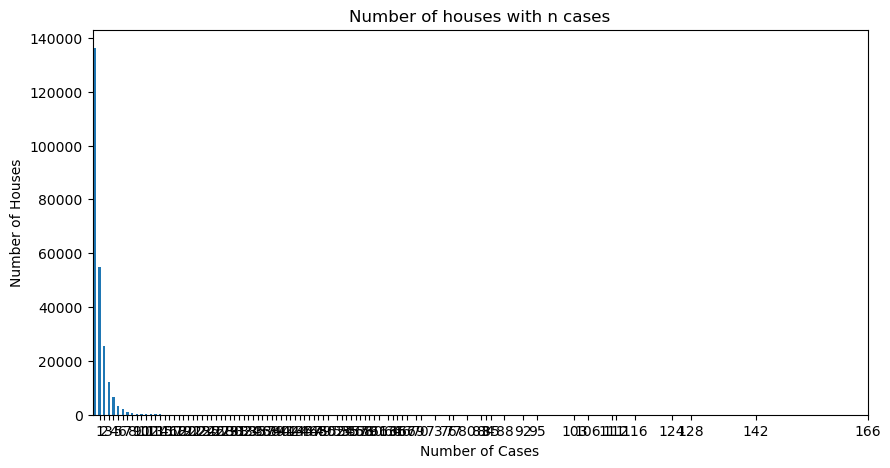

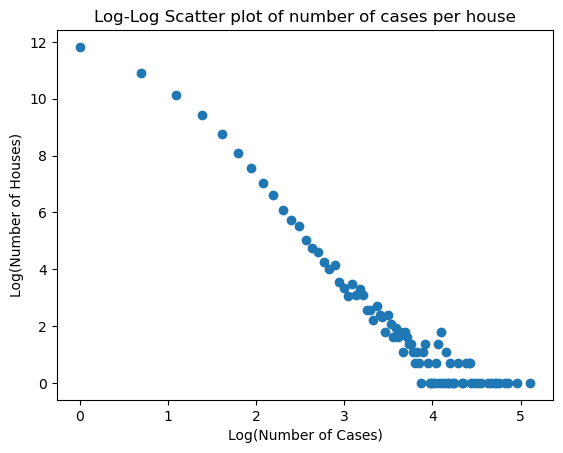

In [9]:
same_coord_cases = dengue_data.groupby(['latitude', 'longitude']).size().reset_index(name='count')
house_with_n_cases = same_coord_cases['count'].groupby(same_coord_cases['count']).count()
pd.set_option('display.max_rows', None)
display(house_with_n_cases)
pd.set_option('display.max_rows', 10)

house_with_n_cases.plot(kind='bar', figsize=(10, 5), title='Number of houses with n cases', xticks=house_with_n_cases.index, xlabel='Number of Cases', ylabel='Number of Houses')
plt.xticks(rotation=0)
plt.show()
plt.scatter(np.log(np.array(house_with_n_cases.index)), np.log(np.array(house_with_n_cases.values)))
plt.title('Log-Log Scatter plot of number of cases per house')
plt.xlabel('Log(Number of Cases)')
plt.ylabel('Log(Number of Houses)')
plt.show()


### Health Centers and Districts

In [10]:
pd.set_option('display.max_rows', None)
dengue_data['abrange'].value_counts()

abrange
NAO DETERMINADA                         422776
C.S.SANTA TEREZINHA                       4542
C.S.PARAISO                               3906
C.S.GLORIA                                3820
C.S.HORTO                                 3521
C.S.MARCO ANTONIO DE MENEZES              3431
C.S.NORALDINO DE LIMA                     3175
C.S.POMPEIA                               3094
C.S.SANTA AMELIA                          3062
C.S.SAO GERALDO                           3017
C.S.LINDEIA                               2888
C.S.VALE DO JATOBA                        2847
C.S.NAZARE                                2772
C.S.SALGADO FILHO                         2694
C.S.ALCIDES LINS                          2619
C.S.JARDIM MONTANHES                      2606
C.S.JARDIM GUANABARA                      2572
C.S.PINDORAMA                             2526
C.S.DOM BOSCO                             2507
C.S.REGINA                                2491
C.S.BARREIRO DE CIMA                      2421
C.S.V

In [11]:
pd.set_option('display.max_rows', 20)
dengue_data['distrito'].value_counts()


distrito
NORDESTE      104799
NORTE          96400
VENDA NOVA     90697
BARREIRO       81132
LESTE          76912
NOROESTE       75865
OESTE          64090
PAMPULHA       61383
CENTRO-SUL     36714
Name: count, dtype: int64

#### Closest Health Centers

In [12]:
# CONTINUE ANALYSIS

### Ovitraps data

In [13]:
ovitraps_data['abrange'].value_counts()


abrange
C.S.SANTA AMELIA               11893
C.S.NOSSA SENHORA DE FATIMA    11772
C.S.CONJ. SANTA MARIA           9643
C.S.TREVO                       8979
C.S.MENINO JESUS                8169
                               ...  
C.S.JOAO XXIII                  1251
C.S.BOA VISTA                   1247
C.S.SANTA LUCIA                 1224
C.S.NOVO AARAO REIS             1063
C.S.ITAMARATI 2                  759
Name: count, Length: 151, dtype: int64

# Create maps

### Cases in BH grouped by coordinates 

In [14]:
filter = 100
coordinates = dengue_data.groupby(['latitude', 'longitude']).size().reset_index(name='count')
coordinates = coordinates[coordinates['count'] > filter].sort_values(by='count', ascending=False).reset_index(drop=True)
coordinates['cluster'] = coordinates.index


mymap = generic.create_map(coordinates[['latitude', 'longitude']].values)
mymap = generic.add_clustered_markers_to_map(mymap, coordinates)

health_centers_coordinates = health_centers[['latitude','longitude']].dropna(axis=0).values
mymap = generic.add_points_to_map(
    mymap=mymap,
    coordinates=health_centers_coordinates,
    size=7
)
generic.save_file(file=mymap,folder='../../results/correlation/', file_name='dengue_cases_by_coordinates.html')
mymap

### Cases in BH grouped by clusters

In [15]:
coordinates = dengue_data[['latitude','longitude']].dropna(axis=0).values
cluster_data = generic.cluster_points(coordinates)
mymap = generic.create_map(coordinates)
mymap = generic.add_clustered_markers_to_map(mymap, cluster_data)

health_centers_coordinates = health_centers[['latitude','longitude']].dropna(axis=0).values
mymap = generic.add_points_to_map(
    mymap=mymap,
    coordinates=health_centers_coordinates,
    size=7
)
generic.save_file(file=mymap,folder='../../results/correlation/', file_name='dengue_cases_by_clusters.html')
mymap

### Cases by Epidemic Year

In [16]:
"""
for year in dengue_data['anoCepid'].unique():
    coord_year = dengue_data[dengue_data['anoCepid'] == year][['latitude','longitude']].dropna(axis=0).values
    if coord_year.shape[0] == 0:
        print(f'No coordinates for year {year}')
        continue
    cluster_data_year = generic.cluster_points(coord_year)
    mymap_year = generic.create_map(coord_year, title=f'Dengue cases in {year}')
    mymap_year = generic.add_clustered_markers_to_map(mymap_year, cluster_data_year)
generic.save_file(file=mymap_year,folder='../../results/correlation/years/', file_name=f'dengue_cases_in_{year}.html')
"""

"\nfor year in dengue_data['anoCepid'].unique():\n    coord_year = dengue_data[dengue_data['anoCepid'] == year][['latitude','longitude']].dropna(axis=0).values\n    if coord_year.shape[0] == 0:\n        print(f'No coordinates for year {year}')\n        continue\n    cluster_data_year = generic.cluster_points(coord_year)\n    mymap_year = generic.create_map(coord_year, title=f'Dengue cases in {year}')\n    mymap_year = generic.add_clustered_markers_to_map(mymap_year, cluster_data_year)\ngeneric.save_file(file=mymap_year,folder='../../results/correlation/years/', file_name=f'dengue_cases_in_{year}.html')\n"

#### GIF

In [17]:
"""
images = [] 
dirname = '../../results/correlation/years/'
for dirpath, _, filenames in os.walk(dirname, topdown=True):
    for file in filenames:
        path = os.path.join(dirname, file)
        path = visualization.convert_html_to_image(path)
        images.append(imageio.imread(path))
        
imageio.mimsave(f'{dirname}map.gif', images, fps = 1)  # 1 second per frame
"""

"\nimages = [] \ndirname = '../../results/correlation/years/'\nfor dirpath, _, filenames in os.walk(dirname, topdown=True):\n    for file in filenames:\n        path = os.path.join(dirname, file)\n        path = visualization.convert_html_to_image(path)\n        images.append(imageio.imread(path))\n        \nimageio.mimsave(f'{dirname}map.gif', images, fps = 1)  # 1 second per frame\n"